### __*Install packages, Imports, DataFrame*__

In [1]:
!pip install -q torch
!pip install -q darts
!pip install -q torchmetrics

from torchmetrics import SymmetricMeanAbsolutePercentageError, MeanSquaredError, MeanAbsoluteError


import torch

from darts.utils.timeseries_generation import (
    gaussian_timeseries,
    linear_timeseries,
    sine_timeseries,
)

from darts.models import (
    RNNModel,
    TCNModel,
    TransformerModel,
    NBEATSModel,
    BlockRNNModel,
    VARIMA,
)

from darts.metrics import mape, smape, mae
from darts.dataprocessing.transformers import Scaler
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.datasets import AirPassengersDataset, MonthlyMilkDataset, ElectricityDataset

import logging

logging.disable(logging.CRITICAL)

import warnings

warnings.filterwarnings("ignore")


%matplotlib inline

import numpy as np

# for reproducibility
torch.manual_seed(1)
np.random.seed(1)



[notice] A new release of pip available: 22.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip available: 22.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip available: 22.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


/Users/edwinblanco/.pyenv/versions/3.10.6/envs/crypto_market_assistant/lib/python3.10/site-packages/statsforecast/core.py:25: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [2]:
# testing

import pandas as pd

import datetime as dt
import matplotlib.pyplot as plt

from darts import TimeSeries
from sklearn.preprocessing import MinMaxScaler


from darts.utils.missing_values import fill_missing_values


In [3]:
df = pd.read_csv(r"/Users/edwinblanco/Desktop/BTCUSDT_daily_Binance.csv")


In [4]:
df.index = pd.to_datetime(df.time)


In [5]:
df.drop(columns="time",inplace=True)


In [6]:
df


,open,high,low,close,volume BTC,volume USD
time,,,,,,
2017-08-17,4261.48,4485.39,4200.74,4285.08,795.150377,3.454770e+06
2017-08-18,4285.08,4371.52,3938.77,4108.37,1199.888264,5.086958e+06
2017-08-19,4108.37,4184.69,3850.00,4139.98,381.309763,1.549484e+06
2017-08-20,4139.98,4211.08,4032.62,4086.29,467.083022,1.930364e+06
2017-08-21,4069.13,4119.62,3911.79,4016.00,691.743060,2.797232e+06
...,...,...,...,...,...,...
2023-11-26,37780.67,37814.63,37150.00,37447.43,21264.537230,7.973212e+08
2023-11-27,37447.42,37569.23,36707.00,37242.70,30001.073760,1.112557e+09
2023-11-28,37242.70,38377.00,36868.41,37818.87,37544.466670,1.414360e+09


### __*Scaling and Converting the data*__

In [7]:
#freq: This parameter defines the frequency or time interval between consecutive data points in the time series.
#'D': It means that each data point in the time series corresponds to an hour

timeseries = TimeSeries.from_dataframe(df, freq='D')


In [8]:
# Here we are converting the MinMax scaler to a Time Series version of it

from darts.dataprocessing.transformers.scaler import Scaler
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
ts_scaler = Scaler(scaler)
ts_scaler_target = Scaler(scaler)


In [9]:

scaled_df = ts_scaler.fit_transform(timeseries)
ts_scaler_target = ts_scaler_target.fit(timeseries["close"])


### __*Cleaning Missing data*__

In [10]:
from darts.utils.missing_values import fill_missing_values
scaled_df = fill_missing_values(scaled_df)
scaled_df


<TimeSeries (DataArray) (time: 2297, component: 6, sample: 1)>
array([[[1.66849011e-02],
        [1.83935731e-02],
        [2.18236933e-02],
        [1.70362814e-02],
        [7.45640064e-04],
        [1.41826479e-04]],

       [[1.70517150e-02],
        [1.66610117e-02],
        [1.76920262e-02],
        [1.42896423e-02],
        [1.27785570e-03],
        [2.35284878e-04]],

       [[1.43051186e-02],
        [1.38183450e-02],
        [1.62919877e-02],
        [1.47809629e-02],
        [2.01454671e-04],
        [3.27306016e-05]],
...
       [[5.29310681e-01],
        [5.34063159e-01],
        [5.37042744e-01],
        [5.38258736e-01],
        [4.90696577e-02],
        [8.09296691e-02]],

       [[5.38266223e-01],
        [5.35173872e-01],
        [5.48107890e-01],
        [5.38814716e-01],
        [4.30862104e-02],
        [7.16665738e-02]],

       [[5.38822195e-01],
        [5.30546152e-01],
        [5.47003883e-01],
        [5.36783530e-01],
        [3.22326319e-02],
        [5.34525650e-02]]])
Coordinates:
  * time       (time) datetime64[ns] 2017-08-17 2017-08-18 ... 2023-11-30
  * component  (component) object 'open' 'high' ... 'volume BTC' 'volume USD'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

### __*Train Test Split*__

<Axes: xlabel='time'>

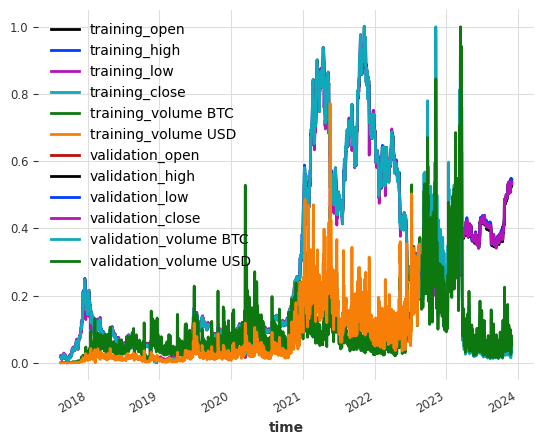

In [11]:
train, val = (scaled_df).split_before(0.8)
train.plot(label="training")
val.plot(label="validation")


### __*Setup Earlystopping and the train on GPU*__

In [12]:
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

# stop training when validation loss does not decrease more than 0.05 (`min_delta`) over
# a period of 5 epochs (`patience`)
stopper = EarlyStopping(
    monitor="val_loss",
    patience=30,
    min_delta=0.005,
    mode='min',
)

"""pl_trainer_kwargs={"callbacks": [stopper],
                   "accelerator": "gpu",
                   "devices": [0]}"""


'pl_trainer_kwargs={"callbacks": [stopper],\n                   "accelerator": "gpu",\n                   "devices": [0]}'

### __*Instanciate our model!!!*__

In [13]:
# predict 15 days considering the latest 45 days

model_covariates = BlockRNNModel(
    model="LSTM",
    input_chunk_length=150,
    output_chunk_length=30,
    dropout=0.2,
    torch_metrics= SymmetricMeanAbsolutePercentageError(),
    #pl_trainer_kwargs = pl_trainer_kwargs,
    random_state=0,
)


### __*Train the model*__

In [14]:
model_covariates.fit(
    series=[train["close"]],    # the target training data
    past_covariates=train,     # the multi covariate features training data
    val_series=[val["close"]],  # the target validation data
    val_past_covariates=val,   # the multi covariate features validation data
    verbose=True,
)


Epoch 99: 100%|██████████| 52/52 [00:02<00:00, 19.14it/s, train_loss=0.00146, val_loss=0.0299, val_SymmetricMeanAbsolutePercentageError=0.304, train_SymmetricMeanAbsolutePercentageError=0.195]   


BlockRNNModel(model=LSTM, hidden_dim=25, n_rnn_layers=1, hidden_fc_sizes=None, dropout=0.2, input_chunk_length=150, output_chunk_length=30, torch_metrics=SymmetricMeanAbsolutePercentageError(), random_state=0)

### __*Do a prediction*__

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 52.29it/s]


<Axes: xlabel='time'>

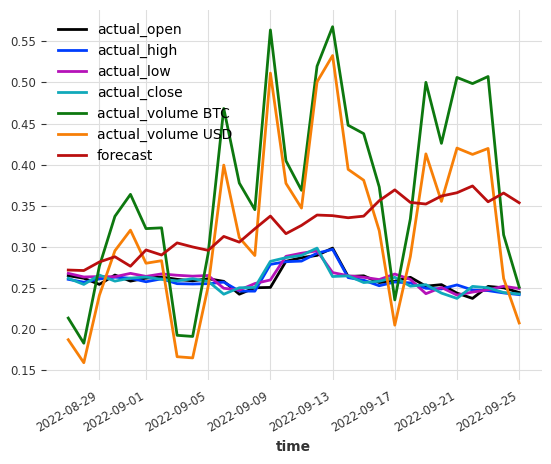

In [15]:
pred_cov = model_covariates.predict(n=30,                        # n of days to predict
                                 series=train["close"][-150:],       # target input for prediction
                                 past_covariates=train[-150:]) # past-covariates input for prediction

val[:30].plot(label="actual")
pred_cov.plot(label="forecast")


### __*Result of the metrics*__

In [16]:
# check the SMAPE error

smape(val['close'][:30], pred_cov)


21.972926383342024

### __*Turn Prediction into original scale*__

In [18]:
ts_scaler_target.inverse_transform(pred_cov).values()


array([[20680.14526337],
       [20641.41035942],
       [21310.5933275 ],
       [21719.80882232],
       [20978.46654052],
       [22251.88021457],
       [21855.52559857],
       [22802.58306556],
       [22484.987253  ],
       [22219.49433558],
       [23309.59924607],
       [22862.27900503],
       [23906.5504393 ],
       [24903.01049066],
       [23524.29262907],
       [24172.3096405 ],
       [24981.43270606],
       [24933.82083853],
       [24769.31268153],
       [24896.28425329],
       [26102.8288717 ],
       [26950.92753439],
       [25969.72890898],
       [25843.18515126],
       [26467.46048277],
       [26725.81648598],
       [27256.40552689],
       [26017.68896125],
       [26702.66222367],
       [25940.82767487]])